# Assignment 2

Продемонстрировать положение No Free Lunch Theorem. (см материалы семинара)   
Качество работы оценивается по accuracy на тестовой выборке согласно пайплайну (см материалы семинара). Метод валидации (если вы его применяете) 5-fold cv.  
В выводе для каждой модели указать какие предположения она делает относительно данных. В выводе указать почему модель плохо / хорошо работает на сгенерированной вами выборке. Использовать пространство признаков размерности 2 при классификации и размерности 1 при регрессии. При возможности, нарисовать выборку на графике (цветами обозначить классы).  


1. Сгенерировать датасет для задачи бинарной классификации (binary crossentropy), 
на котором метод ближайших соседей работает хуже, чем логистическая регрессия. 

2. Сгенерировать датасет для задачи бинарной классификации (binary crossentropy), 
на котором логистическая регрессия работает хуже, чем метод ближайших соседей.

3. Сгенерировать датасет для задачи бинарной классификации (binary crossentropy), 
на котором метод ближайших соседей с косинусной метрикой расстояния работает лучше, чем с евклидовой метрикой.

4. Сгенерировать датасет для задачи регрессии (MSE),
на котором решающее дерево работает хуже, чем линейная регрессия. 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

In [25]:
def linear(x, k, b, noise=0):
    return (k * x + b) + np.random.normal(scale=noise)


def blob(center, size=5, y_dev=0.5, v_dev=0.5, h_dev=0.5):
    center_x, center_y = center
    
    for _ in range(size):
        yield [center_x + np.random.uniform(high=h_dev),
               center_y + np.random.uniform(high=v_dev) + np.random.uniform(high=y_dev) 
              ]

def generate_linear_regression(x_grid=None, noise=0, k=1, b=0):
    y_grid = [linear(x, k, b, noise) for x in x_grid]
    return np.array(x_grid).reshape(-1, 1), np.array(y_grid)


def generate_linear_classification(x_grid=None, noise=0, k1=1, b1=0, k2=1, b2=1):
    x_grid = np.array(x_grid)
    
    X_pos = np.hstack([x_grid.reshape(-1, 1),
                       np.array([linear(x, k1, b1, noise) for x in x_grid]).reshape(-1, 1)
                      ])
    
    X_neg = np.hstack([x_grid.reshape(-1, 1),
                       np.array([linear(x, k2, b2, noise) for x in x_grid]).reshape(-1, 1)
                      ])
    
    X = np.vstack([X_pos, X_neg])
    Y = np.vstack([np.ones(shape=[len(x_grid),]), np.zeros(shape=[len(x_grid),])]).ravel()
    return X, Y 


def generate_blobs_classification(centers, labels, size=10, y_dev=0.5, v_dev=0.5, h_dev=0.5):
    X = list()
    Y = list()
    
    for center, label in zip(centers, labels):
        for sample in blob(center, size, y_dev, v_dev, h_dev):
            X.append(sample)
        Y.extend([label] * size)
    
    return np.array(X), np.array(Y)


def run_experiment(models, dataset_generator, dataset_generator_params, metric, n_folds=5, test_size=0.3):
    scores = dict()
    X, Y = dataset_generator(**dataset_generator_params)
    METRIC_MAP = {'accuracy': accuracy_score, 'neg_mean_squared_error': mean_squared_error}
    
    if n_folds is not None:
        for i, model in enumerate(models):
            model_name = '%s.%s' % (i+1, str(model).split('(')[0])
            scores[model_name] = abs(cross_val_score(model, X, Y, scoring=metric, cv=n_folds).mean())
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

        for i, model in enumerate(models):
            model_name = '%s.%s' % (i+1, str(model).split('(')[0])
            model.fit(X_train, y_train)
            scores[model_name] = METRIC_MAP[metric](y_test, model.predict(X_test))
    
    return scores
    

1. Сгенерировать датасет для задачи бинарной классификации (binary crossentropy), на котором метод ближайших соседей работает хуже, чем логистическая регрессия

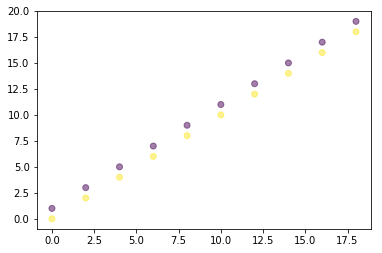

In [38]:
X, Y = generate_linear_classification(range(0, 20, 2), b2=1)
plt.scatter(X[:,0], X[:,1], c=Y, alpha=0.5)

In [37]:
run_experiment([LogisticRegression(), KNeighborsClassifier()],
               generate_linear_classification,
               {'x_grid': range(0, 100, 10), 'b2': 1},
               'accuracy',
              )

{'1.LogisticRegression': 1.0, '2.KNeighborsClassifier': 0.8}

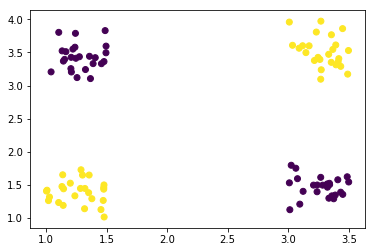

In [15]:
X, Y = generate_blobs([(1, 1), (3, 3), (1, 3), (3, 1)], [1, 1, 0, 0], size=25)
plt.scatter(X[:,0], X[:,1], c=Y)

In [19]:
run_classification([LogisticRegression(), KNeighborsClassifier()],
                   generate_blobs,
                   {'centers': [(1, 1), (3, 3), (1, 3), (3, 1)], 'labels': [1, 1, 0, 0], 'size': 1000}
                  )

{'1.LogisticRegression': 0.25416666666666665, '2.KNeighborsClassifier': 1.0}

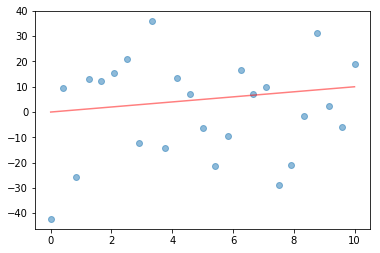

In [43]:
x_grid = np.linspace(0, 10, 25)
X, Y = generate_linear_regression(x_grid, noise=20)
plt.scatter(X, Y, alpha=0.5)
plt.plot(x_grid, x_grid, color='r', alpha=0.5)

In [63]:
run_experiment([DecisionTreeRegressor(), LinearRegression()],
               generate_linear_regression,
               {'x_grid': np.linspace(0, 10, 1000), 'noise': 0},
               'neg_mean_squared_error'
              )

{'1.DecisionTreeRegressor': 0.7418329240151066,
 '2.LinearRegression': 1.3528964524540351e-30}